In [1]:
using CUTEst, NLPModels, Plots, LinearOperators, Krylov, OptimizationProblems, NLSProblems

INFO: Recompiling stale cache file /home/abel/.julia/lib/v0.6/LinearOperators.ji for module LinearOperators.


<h1> JuliaSmoothOptimizers <img src="jsologo-alpha-1000-1000.png" style="width: 300px; display: inline"/> </h1>

<p>
Abel Soares Siqueira - Federal University of Paraná, Brazil
</p>
<p>
Dominique Orban - GERAD/Polytechnique Montreal, Canada
</p>

- Tools for developers/researchers/academics
- Used by ourselves
- Integrates with MPB/JuMP
- We also develop solvers, focusing on large-scale
- Similar work has also been done in [PythonOptimizers](https://github.com/PythonOptimizers)

<img src="jso.png" alt="Drawing" style="width: 600px;"/>

# NLPModels

Defines nonlinear programming types and unified API to access them.

In [2]:
using NLPModels, CUTEst, JuMP

# Short
adnlp = ADNLPModel(x->(x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])

# ROSENBR from the CUTEst list of problem
ctnlp = CUTEstModel("ROSENBR")

# using JuMP -> sparse Hessian
m = Model()
@variable(m, x[1:2])
setvalue(x, [-1.2; 1.0])
@NLobjective(m, Min, (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2)
mpnlp = MathProgNLPModel(m);

In [3]:
# Unified API
for (name, nlp) in [("Autodiff", adnlp), ("CUTEst", ctnlp), ("JuMP", mpnlp)]
    x = nlp.meta.x0
    println("$name")
    println("fx = $(obj(nlp, x))")
    println("gx = $(grad(nlp, x))")
    println("Hx = $(hess(nlp, x))")
    println("")
end
finalize(ctnlp)

Autodiff
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = [1330.0 0.0; 480.0 200.0]

CUTEst
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0

JuMP
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0



In [4]:
using Ipopt

nlp = CUTEstModel("ROSENBR")
model = NLPtoMPB(nlp, IpoptSolver(print_level=0))
MathProgBase.optimize!(model)
finalize(nlp)
println("#f = $(neval_obj(nlp))")
println("#g = $(neval_grad(nlp))")
println("#H = $(neval_hess(nlp))")
println("#Hp = $(neval_hprod(nlp))")
println("Σf = $(sum_counters(nlp))")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

#f = 45
#g = 23
#H = 22
#Hp = 0
Σf = 90


#### General Formulation

\begin{align*}
  \min & \quad f(x) \\
  \text{s. to} & \quad c_{\ell} \leq c(x) \leq c_u \\
  & \quad \ell \leq x \leq u.
\end{align*}

In [5]:
nlp = ADNLPModel(x->sum(x.^4), [1.0; 2.0; 3.0; 4.0],
                lvar=[-1; -Inf; 0; 0], uvar=[1; 0; Inf; 0],
                c=x->[sum(x); prod(x)], lcon=[1.0; 1.0], ucon=[1.0; Inf])

meta = nlp.meta
x = meta.x0
ℓ, u = meta.lvar, meta.uvar
cℓ, cu = meta.lcon, meta.ucon
vartypes = meta.ifix, meta.ifree, meta.ilow, meta.iupp, meta.irng
contypes = meta.jfix, meta.jfree, meta.jlow, meta.jupp, meta.jrng

([1], Int64[], [2], Int64[], Int64[])

In [6]:
cons(nlp, x) # c(x)

2-element Array{Float64,1}:
 10.0
 24.0

In [7]:
jac(nlp, x) # J(x)

2×4 Array{Float64,2}:
  1.0   1.0  1.0  1.0
 24.0  12.0  8.0  6.0

In [8]:
n, m = meta.nvar, meta.ncon
v = ones(n)
jprod(nlp, x, v) # J(x) * v

2-element Array{Float64,1}:
  4.0
 50.0

In [9]:
w = ones(m)
jtprod(nlp, x, w) # J(x)' * v

4-element Array{Float64,1}:
 25.0
 13.0
  9.0
  7.0

Some models handle sparsity (e.g. CUTEst and MathProgNLPModel)

In [10]:
model = Model()
@variable(model, x[1:10], start=1.0)
@NLobjective(model, Min, sum(x[i]^4 for i = 1:10))
@NLconstraint(model, [i=1:9], x[i]^2 - x[i+1] == 1)
nlp = MathProgNLPModel(model)

x = nlp.meta.x0

jac(nlp, x)

9×10 SparseMatrixCSC{Float64,Int64} with 18 stored entries:
  [1 ,  1]  =  2.0
  [1 ,  2]  =  -1.0
  [2 ,  2]  =  2.0
  [2 ,  3]  =  -1.0
  [3 ,  3]  =  2.0
  [3 ,  4]  =  -1.0
  [4 ,  4]  =  2.0
  [4 ,  5]  =  -1.0
  [5 ,  5]  =  2.0
  [5 ,  6]  =  -1.0
  [6 ,  6]  =  2.0
  [6 ,  7]  =  -1.0
  [7 ,  7]  =  2.0
  [7 ,  8]  =  -1.0
  [8 ,  8]  =  2.0
  [8 ,  9]  =  -1.0
  [9 ,  9]  =  2.0
  [9 , 10]  =  -1.0

- To create specific models, we can extend `AbstractNLPModel` and define the functions `obj`, `grad`, etc;
- It can be useful when you know the functions expressions and want to prohibit other functions;
- It can be used to create models on top of models, such as `SlackModel`.

$$ \begin{array}{rl}
\min & \quad f(x) \\
\mbox{s. to} & \quad c(x) \geq 0
\end{array} \qquad \Rightarrow
\qquad
\begin{array}{rl}
\min & \quad f(x) \\
\mbox{s. to} & \quad c(x) - s = 0 \\
& \quad s \geq 0.
\end{array}
$$

In [11]:
model = Model()
@variable(model, x[1:2])
@NLobjective(model, Min, x[1]^2 + x[2]^2)
@constraint(model, x[1] + x[2] >= 1)
nlp = MathProgNLPModel(model)
equality_constrained(nlp)

false

In [12]:
inequality_constrained(nlp)

true

In [13]:
slp = SlackModel(nlp)
slp.meta.nvar

3

In [14]:
equality_constrained(slp)

true

In [15]:
inequality_constrained(slp)

false

## Nonlinear Least Squares

- Residual functions to NLPModels
- Same idea: unified API
- Also works as $f(x) = \sum r_i(x)^2$.

### Main models

- LLSModel(A, b)
- ADNLSModel(F, x0)
- FeasibilityResidual(nlp)
- MathProgNLSModel(model, [expr])

In [16]:
model = Model()
@variable(model, x[1:2])
setvalue(x, [-1.2; 1.0])
@NLexpression(model, F1, x[1] - 1)
@NLexpression(model, F2, x[2] - x[1]^2)
nls = MathProgNLSModel(model, [F1; F2])

residual(nls, nls.meta.x0)

2-element Array{Float64,1}:
 -2.2 
 -0.44

In [17]:
jac_residual(nls, nls.meta.x0)

2×2 SparseMatrixCSC{Float64,Int64} with 3 stored entries:
  [1, 1]  =  1.0
  [2, 1]  =  2.4
  [2, 2]  =  1.0

## Problems Repositories

- [OptimizationProblems.jl](https://github.com/JuliaSmoothOptimizers/OptimizationProblems.jl)
  stores NLP problems in JuMP format. Some problems from CUTEst are implemented. More are welcome.
- [NLSProblems.jl](https://github.com/JuliaSmoothOptimizers/OptimizationProblems.jl)
  stores NLS problems. Moré-Garbow-Hillstrom and some other models are implemented. More are welcome.

In [18]:
using OptimizationProblems

nlp = MathProgNLPModel(dixmaanj())
obj(nlp, nlp.meta.x0)

1281.3263187429854

In [19]:
using NLSProblems

nls = mgh01()
residual(nls, nls.meta.x0)

2-element Array{Float64,1}:
 -4.4
  2.2

## LinearOperators

Factorization-free methods will never use the Jacobian explicitly. Instead, they use the Jacobian products `jprod` and `jtprod`.

LinearOperators appear to work as matrices, but will use matrix-vector products internally.

In [42]:
nlp = MathProgNLPModel(bt1())
x = nlp.meta.x0

T = LinearOperator{Float64}(nlp.meta.ncon, nlp.meta.nvar,
            false, false, # Symmetric? hermitian?
            v->jprod(nlp, x, v),  # T * v  prod(v)
            v->jtprod(nlp, x, v), # T.' * v  tprod(v)
            v->jtprod(nlp, x, v)) # T' * v   ctprod(v)

Linear operator
  nrow: 1
  ncol: 2
  eltype: Float64
  symmetric: false
  hermitian: false
  prod:   #23
  tprod:  #24
  ctprod: #25


In [43]:
T * ones(nlp.meta.nvar)

1-element Array{Float64,1}:
 0.28

In [44]:
T' * ones(nlp.meta.ncon)

2-element Array{Float64,1}:
 0.16
 0.12

LinearOperators are lazy.

In [23]:
T' * T

Linear operator
  nrow: 2
  ncol: 2
  eltype: Float64
  symmetric: false
  hermitian: false
  prod:   LinearOperators.#28
  tprod:  LinearOperators.#29
  ctprod: LinearOperators.#30


In [24]:
(T' * T) * ones(nlp.meta.nvar)

LoadError: [91mjprod not implemented[39m

Also, they're already implemented on NLPModels

In [25]:
jac_op(nlp, x)

LoadError: [91mMethodError: no method matching jac_op(::NLPModels.MathProgNLPModel, ::Array{JuMP.Variable,1})[0m
Closest candidates are:
  jac_op(::NLPModels.AbstractNLPModel, [91m::Array{Float64,1}[39m) at /home/abel/.julia/v0.6/NLPModels/src/NLPModels.jl:219[39m

In [26]:
hess_op(nlp, x)

LoadError: [91mMethodError: no method matching hess_op(::NLPModels.MathProgNLPModel, ::Array{JuMP.Variable,1})[0m
Closest candidates are:
  hess_op(::NLPModels.AbstractNLPModel, [91m::Array{Float64,1}[39m; obj_weight, y) at /home/abel/.julia/v0.6/NLPModels/src/NLPModels.jl:313[39m

## Krylov

Krylov methods are iterative solvers for linear systems, least squares and least norm problems.
It works with matrices and LinearOperators.

In [27]:
using Krylov

A = rand(5, 5)
A = A * A'
b = A * ones(5)
cg(A, b)

([1.0, 1.0, 1.0, 1.0, 1.0], 
Simple stats
  solved: true
  inconsistent: false
  residuals:  [  1.4e+01  1.1e-01  3.6e-02  6.5e-03  1.7e-02  1.6e-09 ]
  Aresiduals: [ ]
  status: solution good enough given atol and rtol
)

$$ \min_{\lambda} \frac{1}{2}\Vert \nabla f(x) - J(x)^T\lambda\Vert. $$

In [28]:
x = nlp.meta.x0
g = grad(nlp, x)
J = jac_op(nlp, x)
λ = cgls(J', g)[1]

1-element Array{Float64,1}:
 96.0

In [29]:
nlp = ADNLPModel(x->sum(x.^4), ones(4))

x = nlp.meta.x0
gx = grad(nlp, x)
while norm(gx) > 1e-4
    Hx = hess_op(nlp, x)
    d = cg(Hx, -gx)[1]
    x += d
    gx = grad(nlp, x)
end
x

4-element Array{Float64,1}:
 0.0173415
 0.0173415
 0.0173415
 0.0173415

In [30]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [31]:
Bx = [2 1; 1 8]
b, t = Bx * ones(2), linspace(0, 1, 100)
q(x,y) = dot([x;y], 0.5 * Bx * [x;y] - b)
@gif for Δ = 0.3 + 1.3 * abs.(1 - 2 * t)
    contour(2 * t - 0.5, 2 * t - 0.5, q, aspect_ratio=:equal, leg=false)
    x = cg(Bx, b, radius=Δ)[1]
    scatter!([x[1]], [x[2]], ms=3, c=:black)
    plot!(Δ * cos.(2π * t), Δ * sin.(2π * t), c=:green, l=:dash)
    xlims!(-0.5, 1.5); ylims!(-0.5, 1.5)
end

INFO: Saved animation to /home/abel/projetos/abel/apresentacoes/2018-06-27-jump-dev/tmp.gif


Plots.AnimatedGif("/home/abel/projetos/abel/apresentacoes/2018-06-27-jump-dev/tmp.gif")

## LBFGS Operator + Krylov

In [32]:
# Create BFGS operator
Bx = LBFGSOperator(2, scaling=false)
Hx = InverseLBFGSOperator(2, scaling=false)

# Update
s = [1.0; 2.0]
y = [0.5; 4.0]
push!(Bx, s, y)
push!(Hx, s, y)

# Use as matrix
v = ones(2)
cg(Bx, v)[1] - Hx * v

2-element Array{Float64,1}:
 2.22045e-16
 0.0        

# Optimize.jl

Inside Optimize.jl, we have tools for line search and trust region.
They can be seen used on the methods `lbfgs`, `trunk` and `tron`.
The package is under a lot of change ATM.

In [33]:
using Optimize

problems = CUTEst.select(only_free_var=true, max_var=2, max_con=0)
sort!(problems)
@printf("%-10s | %11s  %6s  %10s | %11s  %6s  %10s\n",
        "Problem", "f(x)", "Σf", "status", "f(x)", "Σf", "status")
mtds = [lbfgs, trunk]
for p in problems
    nlp = CUTEstModel(p)
    @printf("%-10s", p)
    for mtd in mtds
        try
            reset!(nlp)
            x, fx, ngx, iter, optimal, tired, status = mtd(nlp)
            @printf(" | %+10.4e  %6d  %10s", fx, sum_counters(nlp), status)
        catch ex
            @printf(" | %11s  %6s  %10s\n", "ERROR", "-", "-")
        end
    end
    println("")
    finalize(nlp)
end

Problem    |        f(x)      Σf      status |        f(x)      Σf      status
AKIVA      |       ERROR       -           -
 |       ERROR       -           -

BEALE      |       ERROR       -           -
 |       ERROR       -           -

BOXBODLS   |       ERROR       -           -
 |       ERROR       -           -

BRKMCC     |       ERROR       -           -
 |       ERROR       -           -

BROWNBS    |       ERROR       -           -
 |       ERROR       -           -

CLIFF      |       ERROR       -           -
 |       ERROR       -           -

CUBE       |       ERROR       -           -
 |       ERROR       -           -

DANWOODLS  |       ERROR       -           -
 |       ERROR       -           -

DENSCHNA   |       ERROR       -           -
 |       ERROR       -           -

DENSCHNB   |       ERROR       -           -
 |       ERROR       -           -

DENSCHNC   |       ERROR       -           -
 |       ERROR       -           -

DENSCHNF   |       ERROR      

In [34]:
problems = CUTEst.select(only_free_var=true, max_var=2, max_con=0)
sort!(problems)
mtds = [lbfgs, trunk]
np, nm = length(problems), length(mtds)
P = fill(-1, np, nm)
for (i,p) in enumerate(problems)
    nlp = CUTEstModel(p)
    for (j,mtd) in enumerate(mtds)
        try
            reset!(nlp)
            stats = mtd(nlp, max_f=1000)
            if stats.status == :first_order
                P[i,j] = sum_counters(nlp)
            end
        end
    end
    finalize(nlp)
end

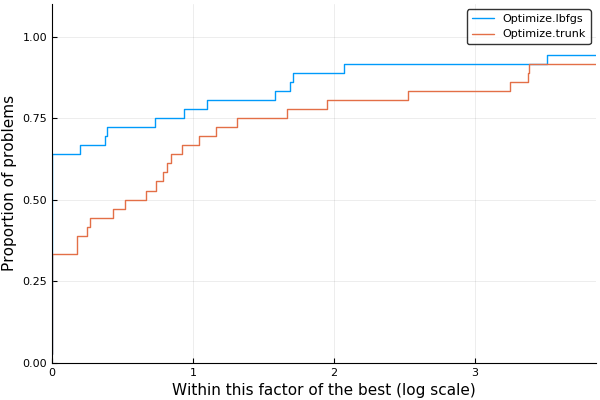

In [35]:
using BenchmarkProfiles

performance_profile(P, string.(mtds))

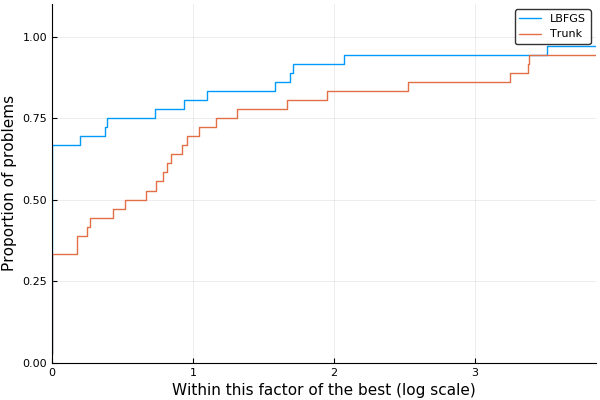

In [36]:
stats, p = Optimize.bmark_and_profile(
                Dict{Symbol,Function}(:LBFGS => lbfgs, :Trunk => trunk),
                (CUTEstModel(p) for p in problems))
[stats[:LBFGS] stats[:Trunk]]
p

# Thank you

## Example solver

$$ \min\ f(x) \qquad \text{s. to} \qquad c(x) = 0. $$

Solve for $d_x$
$$ \left[\begin{array}{cc}
B_k & A_k^T \\ A_k & 0
\end{array}\right]
\left[\begin{array}{c}
d_x \\ d_{\lambda}
\end{array}\right]
=
- \left[\begin{array}{c}
g_k + A_k^T\lambda_k \\ c_k
\end{array}\right]$$

Line search on merit function $\varphi(x;\mu) = f(x) + \mu \Vert c(x)\Vert_1$
$$ \varphi(x + td_x; \mu) < \varphi(x; \mu) + \alpha t D\phi(x, d_x, \mu). $$

In [37]:
using Krylov

function sqp(nlp :: AbstractNLPModel; atol = 1e-4, rtol = 1e-6, ctol = 1e-6,
             max_iter = 10_000, max_f = 10_000, max_time = 60.0)
    if !equality_constrained(nlp)
        error("This solver is for equality constrained problems")
    elseif has_bounds(nlp)
        error("Can't handle bounds")
    end

    n, m = nlp.meta.nvar, nlp.meta.ncon
    
    x = nlp.meta.x0

    fx = obj(nlp, x)
    cx = cons(nlp, x)
    normcx = norm(cx, 1)

    ∇fx = grad(nlp, x)
    Jx = jac(nlp, x)

    λ = cgls(Jx', -∇fx)[1]
    ∇ℓx = ∇fx + Jx'*λ
    norm∇ℓx = norm(∇ℓx)
    
    Hxλ = hess(nlp, x, y=λ) + 1e-12 * speye(n, n)
    
    xt = copy(x)
    ct = copy(cx)
    
    Δ = max(0.1, min(100.0, 10norm∇ℓx))
    μ = 1.0
    
    iter = 0
    ϵ = atol + rtol * norm∇ℓx
    t₀ = time()
    Δt = 0.0
    
    solved = norm∇ℓx < ϵ && normcx < ctol
    tired = iter > max_iter || sum_counters(nlp) > max_f || Δt > max_time

    status = :unknown
    while !(solved || tired)
        W = Symmetric([Hxλ spzeros(n, m); Jx -1e-12*speye(m)], :L)
        F = ldltfact(Symmetric(W, :L))
        d = F \ [-∇ℓx; -cx]
        dx = d[1:n]
        dλ = d[n+1:end]
        
        gᵀd = dot(dx, ∇fx)
        if normcx > 0.0 && μ <= gᵀd / normcx
            μ = gᵀd / normcx + 1
        end
        ϕx = fx + μ * normcx # f(x) + μ ‖c(x)‖₁
        Dϕ = gᵀd - μ * normcx
        
        t = 1.0
        xt .= x + t * dx
        ft = obj(nlp, xt)
        ct .= cons(nlp, xt)
        normct = norm(ct, 1)
        ϕt = ft + μ * normct
        while !(ϕt < ϕx + 1e-2 * t * Dϕ)
            t /= 2.0
            if t < 1e-12
                status = :short_step
                break
            end
            xt .= x + t * dx
            ft = obj(nlp, xt)
            ct .= cons(nlp, xt)
            normct = norm(ct, 1)
            ϕt = ft + μ * normct
        end
        status != :unknown && break
        
        x .= xt
        fx = ft
        cx .= ct
        normcx = normct
        
        ∇fx = grad(nlp, x)
        Jx = jac(nlp, x)

        λ = cgls(Jx', -∇fx)[1]
        ∇ℓx = ∇fx + Jx'*λ
        norm∇ℓx = norm(∇ℓx)

        Hxλ = hess(nlp, x, y=λ) + 1e-12 * speye(n, n)
        
        iter += 1
        Δt = time() - t₀
        solved = norm∇ℓx < ϵ && normcx < ctol
        tired = iter > max_iter || sum_counters(nlp) > max_f || Δt > max_time
    end
    
    if solved
        status = :first_order
    elseif tired
        if iter > max_iter
            status = :max_iter
        elseif Δt > max_time
            status = :max_time
        else
            status = :max_evals
        end
    end

    return x, fx, norm∇ℓx, normcx, Δt, status
end

sqp (generic function with 1 method)

In [38]:
model = Model()
@variable(model, x[1:2], start=0.0)
@NLobjective(model, Min, (x[1] - 1.0)^2 + 100 * (x[2] - x[1]^2)^2)
@NLconstraint(model, x[1] + x[2] == 1.0)
nlp = MathProgNLPModel(model)
sqp(nlp)

([0.618796, 0.381204], 0.14560701802827003, 3.3635988397083165e-6, 3.1086244689504383e-15, 0.4375600814819336, :first_order)

In [39]:
using Ipopt

function ipopt(nlp :: AbstractNLPModel; kwargs...)
    model = NLPtoMPB(nlp, IpoptSolver(print_level=0))
    Δt = time()
    MathProgBase.optimize!(model)
    x = MathProgBase.getsolution(model)
    λ = MathProgBase.getconstrduals(model)
    gx = grad(nlp, x)
    dual = norm(gx + jtprod(nlp, x, λ))
    cx = cons(nlp, x)
    b = nlp.meta.lcon
    primal = norm(cx - b, 1)
    
    Δt = time() - Δt
    status = MathProgBase.status(model)

    return x, obj(nlp, x), dual, primal, Δt, status
end

ipopt (generic function with 1 method)

In [40]:
ipopt(nlp)

([0.618796, 0.381204], 0.1456070180282598, 0.96372276821365, 0.0, 0.07450294494628906, :Optimal)

In [41]:
problems = filter(x->contains(x, "HS") && length(x) <= 5,
            CUTEst.select(only_free_var=true, only_equ_con=true))
sort!(problems)
@printf("%-7s | %15s  %7s  %15s | %15s  %7s %15s\n",
        "Problem", "f(x)", "Δt", "status", "f(x)", "Δt", "status")
mtds = [sqp, ipopt]
for p in problems
    nlp = CUTEstModel(p)
    @printf("%-7s", p)
    for mtd in mtds
        try
            x, fx, nlx, ncx, Δt, status = mtd(nlp)
            @printf(" | %15.8e  %7.3f  %15s", fx, Δt, status)
        catch ex
            @printf(" | %15s  %7s  %15s\n", "-", "-", ex.msg)
        end
    end
    println("")
    finalize(nlp)
end

Problem |            f(x)       Δt           status |            f(x)       Δt          status
HS26    |  3.10249816e-12    0.001      first_order |  1.84236926e-16    0.015          Optimal
HS27    |  3.99999991e-02    0.001      first_order |  4.00000000e-02    0.001          Optimal
HS28    |  3.08148791e-33    0.000      first_order |  3.08148791e-33    0.000          Optimal
HS39    | -1.00000000e+00    0.001      first_order | -1.00000000e+00    0.000          Optimal
HS40    | -2.50000000e-01    0.000      first_order | -2.50000000e-01    0.000          Optimal
HS42    |  1.38578644e+01    0.000      first_order |  1.38578644e+01    0.000          Optimal
HS46    |  9.39073377e-12    0.001      first_order |  5.58198553e-16    0.002          Optimal
HS47    |  1.15600712e-10    0.001      first_order |  2.83015870e-14    0.001          Optimal
HS48    |  1.23259516e-32    0.000      first_order |  1.23259516e-32    0.001          Optimal
HS49    |  4.57324604e-06    0.001      f